**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
# # показывать выдачу всех строк ячейки
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [3]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

## генерируем датасет

(1000, 2) (1000,)


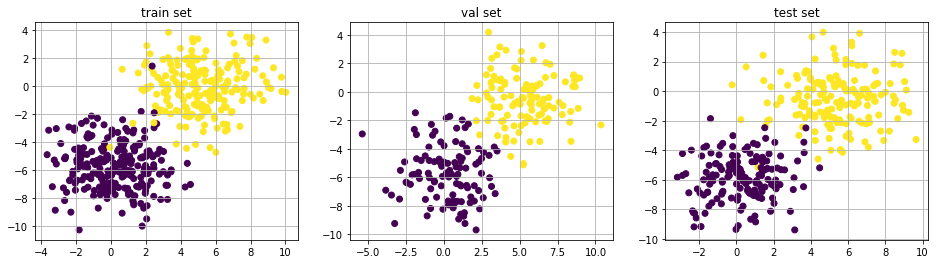

In [14]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )
print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

## LinearModel  + MSQE + GD

In [15]:
# преобразуем список меток к размерности выхода модели
y_train = np.eye(target_train.max()+1)[target_train]
y_val = np.eye(target_val.max()+1)[target_val]
y_test = np.eye(target_test.max()+1)[target_test]
y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [16]:
from lib.model.linear import LinearModel # простая линейная модель x.dot(w)
# LinearModel(n_features,n_out)
model = LinearModel(n_features=X_train.shape[1],n_out=y_train.shape[1] )

In [17]:
from lib.loss.msqe import MSQE # ф-ция потери - cреднеквадратическое отклонение
loss = MSQE(model)

In [18]:
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
lra = ConstLRA(.01)

In [19]:
from lib.optimizer.gd import GD # метод оптимизации градиентный спуск
# GD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.) 
# GD.fit(data_train,data_val=None,n_epoch=2)

In [23]:
# del model

In [21]:
model = GD(
    loss=loss,
    lra=lra,
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
)

100%|██████████| 15/15 [00:00<00:00, 633.66it/s, loss=0.953, lr=0.01]


Threshold value is:0.0036247751659983897

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       152
           1       0.97      0.98      0.97       178

    accuracy                           0.97       330
   macro avg       0.97      0.97      0.97       330
weighted avg       0.97      0.97      0.97       330



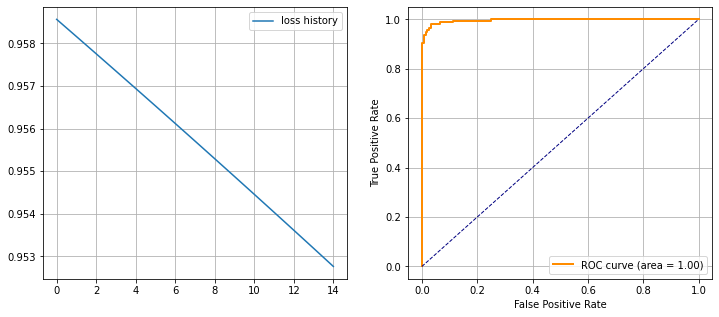

In [22]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# ClassifierEstimator(target,predict_score,loss_history)

ClassifierEstimator(
    target=target_test, 
    predict_score=model.predict(X_test)[:,1],  
    loss_history=loss.history, 
).estimate()

In [ ]:
## FactorLRA

In [ ]:
# from lib.optimizer.lrate import ConstLRA
# lr =  ConstLRA(.1)
# [ lr.next() for _ in range(100) ]
# lr.history

In [ ]:
# from lib.optimizer.lrate import FactorLRA
# lr =  FactorLRA(value=.9,bound=.01,factor=.9,)
# v = [ lr.next() for _ in range(100)] 
# plt.plot(lr.history)
# plt.grid()

## LogisticRegression + BCE + SGD

In [ ]:
# преобразуем список меток к размерности выхода модели
y_train = target_train[:,np.newaxis]
y_val = target_val[:,np.newaxis]
y_test = target_test[:,np.newaxis]
y_train.shape,y_val.shape,y_test.shape

In [ ]:
from lib.model.linear import LogisticRegression # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
# LogisticRegression(n_features=0)
model = LogisticRegression(n_features=X_train.shape[1] )

In [ ]:
from lib.loss.crossentropy import BCE # ф-ция потери - категориальная кросс-энтропия
loss = BCE(model)

In [ ]:
from lib.optimizer.lrate import FactorLRA # скорость обучения - уменьшается в процессе обучения
# FactorLRA(start,bound,factor,)
lra = FactorLRA(.5,bound=.01,factor=.9,)

In [ ]:
from lib.optimizer.breaker import EarlyStopping # прерывание при достижении прога значения ф-ции потери
# EarlyStopping( bound=None, min_delta=0., max_delta=None, patience=2 )
es = EarlyStopping(bound=1e-2)

In [ ]:
from lib.optimizer.regularizator import RegularizationL1 # регуляризация
# RegularizationL1(rho)
reg = RegularizationL1(rho=.01)

In [ ]:
from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [ ]:
model = SGD(
    loss=loss,
    lra=lra,
    breaker=es,
    regul=reg,
    momentum=.01,    
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
    batch_size=y_train.shape[0]//10,
)

In [ ]:
y_ = y[:,np.newaxis]

model = LogisticRegression(n_features=X.shape[1] )
lra=ConstLRA(.1)
es=EarlyStopping(bound=.17)
lsh,lrh = SGD(BCE(model),lra=lra,es=es).fit([X,y_],n_epoch=10,batch_size=X.shape[0]//3)
p = model.predict(X)

ClassifierEstimator( target=y, predict_score=p, loss_history=lsh, ).estimate()

## Softmax  + CCE + SGD

In [ ]:
from lib.model.linear import Softmax
from lib.optimizer.gd import SGD
from lib.loss.crossentropy import CCE

%xdel model 

y_ = np.eye(y.max()+1)[y]
print(y_.shape)

model = Softmax(n_features=X.shape[1],n_out=y_.shape[1] )

lsh,lrh = SGD(CCE(model),lra=ConstLRA(.1)).fit([X,y_],n_epoch=10,batch_size=X.shape[0]//2)
p = model.predict(X)[:,0]

ClassifierEstimator( target=y, predict_score=p,  loss_history=lsh, ).estimate()

In [ ]:
# np.square(np.array(range(6)).reshape(2,3) )

---